<a href="https://colab.research.google.com/github/anuvaagarwal/project_imdb/blob/main/Anuva_PART_II_ML_Model_Amazon_Audible.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART II - Model for IMDb Movie Ratings Prediction
> Author: Anuva Agarwal

(Part I consisting of the report and data pre-processing is in another file)



In [ ]:
# Loading Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [ ]:
#Checking files in colab memory
dir()

In [ ]:
!ls /gdrive/MyDrive/Datasets

df_movies_concatenated_no_encoded_profession.csv  one_hot_encoded_profession.csv
df_movies.csv					  title.akas.tsv.gz
df_movies_final_clean.csv			  title.basics.tsv.gz
df_movies_final_concat.csv			  title.crew.tsv.gz
df_movies_master.csv				  title.episode.tsv.gz
df_split_professions.csv			  title.principals.tsv.gz
name.basics.tsv.gz				  title.ratings.tsv.gz


## Loading Data

In [ ]:
df_movie = pd.read_csv('/gdrive/MyDrive/Datasets/df_movies_final_clean.csv')

In [ ]:
display(df_movie.head(10), df_movie.shape)

,tconst,titleType,isAdult,startYear,movie_age,runtimeMinutes,averageRating,numVotes,title_region_count,genre_Adult,...,genre_Documentary,genre_Crime,genre_Musical,genre_Adventure,genre_Music,genre_Thriller,genre_Game-Show,genre_Romance,genre_Mystery,genre_Reality-TV
0,tt0000001,short,0,1894,130,1.0,5.7,2034,8.0,0,...,1,0,0,0,0,0,0,0,0,0
1,tt0000005,short,0,1893,131,1.0,6.2,2737,8.0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0000006,short,0,1894,130,1.0,5.0,183,6.0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0000007,short,0,1894,130,1.0,5.4,849,7.0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0000008,short,0,1894,130,1.0,5.4,2179,7.0,0,...,1,0,0,0,0,0,0,0,0,0
5,tt0000036,short,0,1896,128,1.0,4.4,620,3.0,0,...,0,0,0,0,0,0,0,0,0,0
6,tt0000076,short,0,1896,128,1.0,4.5,550,3.0,0,...,0,0,0,0,0,0,0,0,0,0
7,tt0000108,short,0,1896,128,1.0,4.4,559,3.0,0,...,0,0,0,0,0,0,0,0,0,0
8,tt0000109,short,0,1896,128,1.0,4.5,540,3.0,0,...,0,0,0,0,0,0,0,0,0,0
9,tt0000110,short,0,1896,128,1.0,4.4,546,3.0,0,...,0,0,0,0,0,0,0,0,0,0


(995285, 37)

In [ ]:
df_movie.columns

Index(['tconst', 'titleType', 'isAdult', 'startYear', 'runtimeMinutes',
       'averageRating', 'numVotes', 'title_region_count', 'genre_Adult',
       'genre_Biography', 'genre_Action', 'genre_Film-Noir', 'genre_Animation',
       'genre_Talk-Show', 'genre_Comedy', 'genre_Horror', 'genre_Sport',
       'genre_Fantasy', 'genre_History', 'genre_News', 'genre_War',
       'genre_Family', 'genre_Western', 'genre_Sci-Fi', 'genre_Drama',
       'genre_Short', 'genre_Documentary', 'genre_Crime', 'genre_Musical',
       'genre_Adventure', 'genre_Music', 'genre_Thriller', 'genre_Game-Show',
       'genre_Romance', 'genre_Mystery', 'genre_Reality-TV'],
      dtype='object')

In [ ]:
df_movie['runtimeMinutes'].value_counts()

30.0       47015
60.0       41413
22.0       39017
90.0       30223
24.0       28932
           ...  
1143.0         1
712.0          1
924.0          1
406.0          1
51420.0        1
Name: runtimeMinutes, Length: 802, dtype: int64

In [ ]:
print("Number of movies/titles with runtime more than 1000 minutes", df_movie[df_movie['runtimeMinutes'] > 300].shape[0])
print("Number of movies/titles with runtime less than 10 minutes", df_movie[df_movie['runtimeMinutes'] < 10].shape[0])

Number of movies/titles with runtime more than 1000 minutes 2114
Number of movies/titles with runtime less than 10 minutes 70283


In [ ]:
df_movie[df_movie['runtimeMinutes'] < 10].groupby('titleType').count()

# Majority of the films of duration less than 10minutes are tv episodes or short films (#49307), with short films forming ~70% of that number.

,tconst,isAdult,startYear,movie_age,runtimeMinutes,averageRating,numVotes,title_region_count,genre_Adult,genre_Biography,...,genre_Documentary,genre_Crime,genre_Musical,genre_Adventure,genre_Music,genre_Thriller,genre_Game-Show,genre_Romance,genre_Mystery,genre_Reality-TV
titleType,,,,,,,,,,,,,,,,,,,,,
movie,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
short,49307,49307,49307,49307,49307,49307,49307,48995,49307,49307,...,49307,49307,49307,49307,49307,49307,49307,49307,49307,49307
tvEpisode,11763,11763,11763,11763,11763,11763,11763,4445,11763,11763,...,11763,11763,11763,11763,11763,11763,11763,11763,11763,11763
tvMiniSeries,420,420,420,420,420,420,420,418,420,420,...,420,420,420,420,420,420,420,420,420,420
tvMovie,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
tvSeries,2065,2065,2065,2065,2065,2065,2065,2048,2065,2065,...,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065
tvShort,830,830,830,830,830,830,830,826,830,830,...,830,830,830,830,830,830,830,830,830,830
tvSpecial,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
video,5821,5821,5821,5821,5821,5821,5821,5729,5821,5821,...,5821,5821,5821,5821,5821,5821,5821,5821,5821,5821


We can truncate the dataframe to include movies between 10minutes and 300 minutes in length since both of these categories would lop off just about 72,397 titles from a dataset of 995,285 titles.

In [ ]:
# Filter movies with runtimeMinutes between 10 and 300
df_movies_truncated = df_movie[(df_movie['runtimeMinutes'] >= 10) & (df_movie['runtimeMinutes'] <= 300)]

df_movies_truncated.shape


(922888, 37)

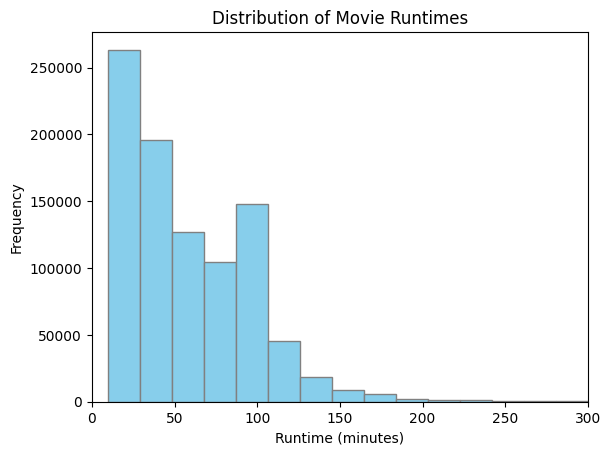

In [ ]:
# Plot histogram of 'runtimeMinutes'
plt.hist(df_movies_truncated['runtimeMinutes'], bins=15, color='skyblue', edgecolor='grey')

plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Runtimes')

# Set limits on x-axis
plt.xlim(0, 300)  # Adjust the limits as needed

plt.show()

In [ ]:
# Standardizing numVotes, movie_age, and runtime

# Initialize StandardScaler
scaler = StandardScaler()

# Define columns to be standardized
columns_to_standardize = ['numVotes', 'movie_age', 'runtimeMinutes']

# Standardize selected columns
df_movies_truncated.loc[:, columns_to_standardize] = scaler.fit_transform(df_movies_truncated[columns_to_standardize])


In [ ]:
df_movies_truncated.head()

,tconst,titleType,isAdult,startYear,movie_age,runtimeMinutes,averageRating,numVotes,title_region_count,genre_Adult,...,genre_Documentary,genre_Crime,genre_Musical,genre_Adventure,genre_Music,genre_Thriller,genre_Game-Show,genre_Romance,genre_Mystery,genre_Reality-TV
121,tt0000004,short,0,1892,5.189158,-1.245043,5.4,-0.062175,7.0,0,...,0,0,0,0,0,0,0,0,0,0
129,tt0094205,movie,0,1979,1.063897,0.569961,6.6,-0.068634,8.0,0,...,0,1,0,0,0,0,0,0,0,0
130,tt1050182,short,0,1965,1.727732,-1.245043,6.0,-0.069650,2.0,0,...,0,0,0,0,0,0,0,0,0,0
131,tt0001223,short,0,1910,4.335656,-1.138278,6.4,0.146090,7.0,0,...,0,0,0,0,0,0,0,0,0,0
132,tt0004457,movie,0,1914,4.145989,0.596653,5.5,-0.044505,5.0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Exploring truncated dataset
df_movies_truncated['title_region_count'].nunique() #85
df_movies_truncated['titleType'].value_counts()

tvEpisode       413540
movie           275223
short            88100
tvSeries         47567
tvMovie          44078
video            37348
tvMiniSeries      8061
tvSpecial         7609
tvShort           1254
videoGame          108
Name: titleType, dtype: int64

In [ ]:
# THIS CELL KEPT ONLY FOR SELF NOTES
# # Replace missing values in 'title_region_count' column with 0
# df_movies_truncated['title_region_count'].fillna(0, inplace=True)

# # Warning with this command. Explanation: The warning you're encountering (SettingWithCopyWarning) typically occurs when you're trying to modify
# # a DataFrame that is actually a view of another DataFrame, rather than a copy. To avoid this warning, you can explicitly make a copy of the DataFrame before modifying it.

In [ ]:
# Make a copy of the DataFrame to solve above warning
df_movies_truncated_copy = df_movies_truncated.copy()

# Replace missing values in 'title_region_count' column with 0 in the copied DataFrame
df_movies_truncated_copy['title_region_count'].fillna(0, inplace=True)


In [ ]:
# Convert 'title_region_count' column to integer
df_movies_truncated_copy['title_region_count'] = df_movies_truncated_copy['title_region_count'].astype(int)

In [ ]:
#'averageRating' is the target variable
X = df_movies_truncated_copy.drop(columns=['averageRating', 'tconst', 'startYear', 'titleType'])
y = df_movies_truncated_copy['averageRating']


In [ ]:
# Specify the number of entries you want to sample
n_samples = 10000

# Sample from X and y
X_sampled = X.sample(n=n_samples, random_state=50)
y_sampled = y.loc[X_sampled.index]

# Verify the shape of the sampled data
print("Shape of X_sampled:", X_sampled.shape)
print("Shape of y_sampled:", y_sampled.shape)


Shape of X_sampled: (10000, 33)
Shape of y_sampled: (10000,)


In [ ]:
X_sampled.isna().sum()

In [ ]:
# Split Data into Training and Testing Sets for random sample:
from sklearn.model_selection import train_test_split

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)


## **Random Forest on Sample**

In [ ]:
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=50)
rf_model.fit(X_train_sample, y_train_sample)

# Make predictions on the test set
y_pred_sample = rf_model.predict(X_test_sample)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test_sample, y_pred_sample)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 1.2383791607888268


## **Linear Regression on Sample**

In [ ]:
# Initialize Linear Regression model
ln_model = LinearRegression()

# Train the model
ln_model.fit(X_train_sample, y_train_sample)

# Make predictions on the test set
y_pred_sample = ln_model.predict(X_test_sample)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test_sample, y_pred_sample)

print(f'Mean Squared Error (MSE): {mse}')


## **Random Forest with complete dataset**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and temp sets (60% train, 40% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temp set into test and validation sets (50% test, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# train, test, and validation sets
# 60-20-20 split


In [ ]:
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=50)
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val)

# Evaluate the model using Mean Squared Error (MSE)
mse_rf = mean_squared_error(y_val, y_pred_rf)
print(f'Mean Squared Error (MSE): {mse_rf}')

root_mse_rf = np.sqrt(mse_rf)
print(f'Root Mean Squared Error (RMSE): {root_mse_rf}')

Mean Squared Error (MSE): 1.0587428405308277
Root Mean Squared Error (RMSE): 1.0289523023594571


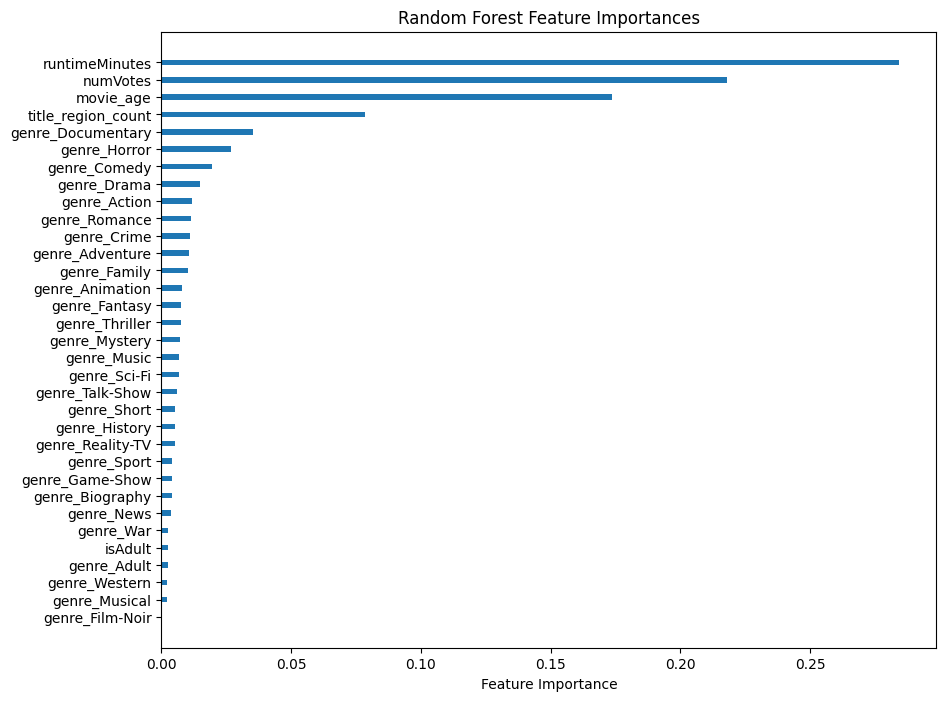

In [ ]:
# Checking Feature importance in Random Forest
feature_importances = rf_model.feature_importances_

# Get the indices of features sorted by importance
sorted_idx = np.argsort(feature_importances)
yticks_positions = np.arange(len(sorted_idx)) * 2.5 #2.5 is spacing

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(yticks_positions, feature_importances[sorted_idx], align="center")

plt.yticks(yticks_positions, X_train.columns[sorted_idx])

plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

## **Linear Regression with complete dataset**

In [ ]:
# Initialize Linear Regression model
ln_model = LinearRegression()

# Train the model
ln_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_ln = ln_model.predict(X_val)

# Evaluate the model using Mean Squared Error (MSE)
mse_ln = mean_squared_error(y_val, y_pred_ln)
root_mse_ln = np.sqrt(mse_ln)

print(f'Mean Squared Error (MSE): {mse_ln}')
print(f'Root Mean Squared Error (MSE): {root_mse_ln}')

Mean Squared Error (MSE): 1.495663287092642
Root Mean Squared Error (MSE): 1.2229731342481085
R-squared: 0.15199306204456342


[-6.86872891e-01 -1.27350003e-01 -3.01488363e-01  1.16581917e-01
 -2.73591396e-02  5.54767779e-01  1.62197900e-01 -4.13133695e-04
  2.86359138e-01  9.74646897e-02 -2.67124143e-01  6.08231955e-02
 -8.00559473e-01  3.19870984e-01  2.38066598e-01  2.91052735e-01
 -2.53496881e-01  2.45879955e-01  9.01046008e-02  4.66413525e-01
 -1.71977542e-01  3.32567626e-01 -2.12699545e-01  4.75763247e-01
  1.81889332e-01 -2.21471718e-01  1.50466349e-01  3.42156952e-01
 -3.07114970e-01  2.37882690e-01 -4.72558469e-03  1.78120906e-01
  6.18344732e-02]
[ 7 30  4 11 32 18  9  3  1 26  6 20 31 24 22 25 29 14 17 16 10  8 15  2
 28 13 21 27 19 23  5  0 12]


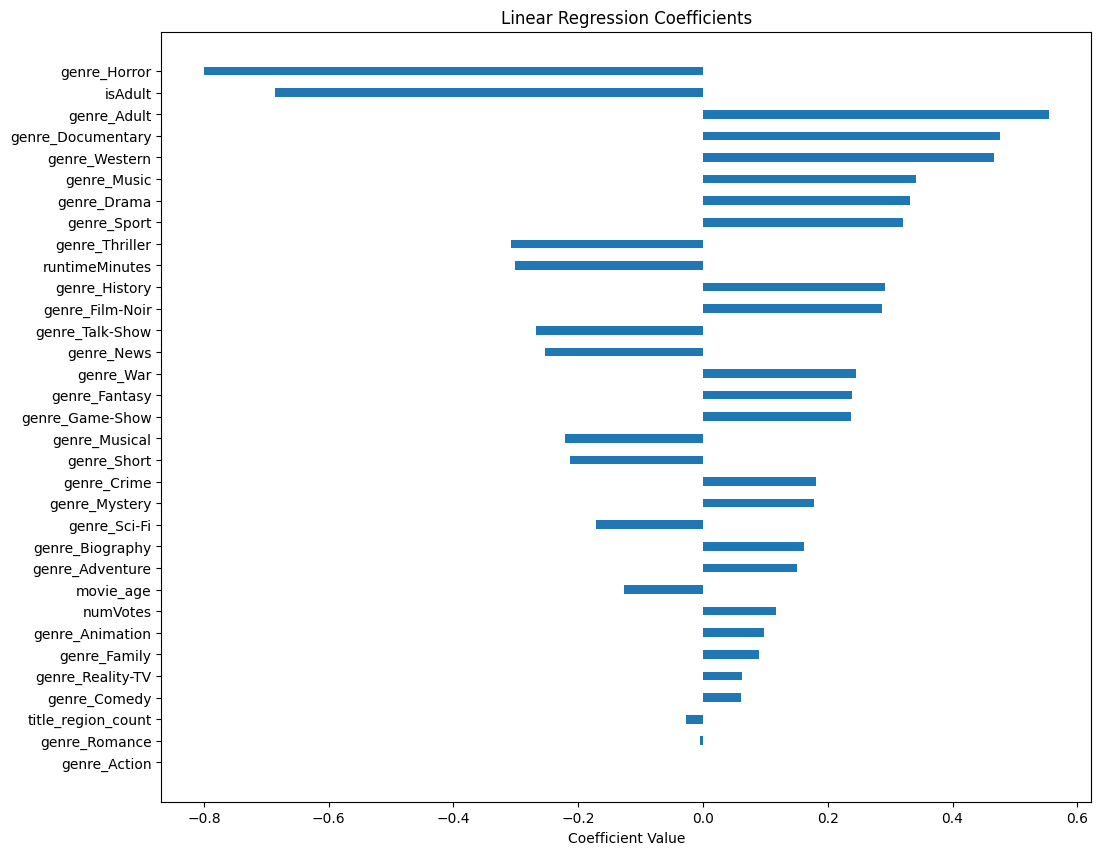

In [ ]:
# Linear Regression Feature Importance

coefficients = ln_model.coef_
print(coefficients)
feature_names = X_train.columns

# Get the indices of features sorted by absolute coefficient values
sorted_idx = np.argsort(np.abs(coefficients))
print(sorted_idx)
yticks_positions = np.arange(len(sorted_idx)) * 2 # 2 is spacing

# Plot feature coefficients
plt.figure(figsize=(12, 10))
plt.barh(yticks_positions, coefficients[sorted_idx], align="center")

plt.yticks(yticks_positions, feature_names[sorted_idx])

plt.xlabel("Coefficient Value")
plt.title("Linear Regression Coefficients")
plt.show()

## **XGBoost with complete dataset**

In [ ]:
# Train the XGBoost Model:
# Create an XGBoost regressor and fit it to your training data.

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# Make predictions on validation set
y_pred_xgb = xg_reg.predict(X_val)

# Evaluate performance
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)

print("Mean Squared Error:", mse_xgb)
print("R-squared:", r2_xgb)

Mean Squared Error: 1.2289966474902065
R-squared: 0.3031869587294931


## **Cross Validation**

Using k-fold cross validation with k=5

In [ ]:
#invoking KFold class from scikit-learn
from sklearn.model_selection import KFold

# Define the number of folds
n = 5

# Initialize KFold cross-validation
kf = KFold(n_splits = n, shuffle=True, random_state=50)


### K-fold CV for Linear Regression

The CV loop for both models is running entirely on X_train, which is divided into 5 folds.

In [ ]:
# Initialize lists to store evaluation metrics
mse_scores_ln = []

# Loop through each fold
for train_index, val_index in kf.split(X):
    # Split data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_val, y_pred)
    mse_scores_ln.append(mse)

In [ ]:
# Aggregating results
mean_mse_ln = np.mean(mse_scores_ln)
print("Mean MSE for Linear Regression:", mean_mse_ln)


Mean MSE for Linear Regression: 1.4921289355678646


### K-fold CV for Random Forest


In [ ]:
# Initialize lists to store evaluation metrics
mse_scores_rf = []

# Loop through each fold
for train_index, val_index in kf.split(X):
    # Split data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Initialize and train the model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_val, y_pred)
    mse_scores_rf.append(mse)

In [ ]:
# Aggregating results
mean_mse_rf = np.mean(mse_scores_rf)
print("Mean MSE for Random Forest:", mean_mse_rf)

Mean MSE for Random Forest: 1.0500583388801885


### K-fold CV for Lasso
Results of CV used in Lasso Regression to identify feature importance

In [ ]:
lasso = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100],
                cv=kf).fit(X_train, y_train)

In [ ]:
# Alpha value chosen by CV:
lasso.alpha_

0.001

In [ ]:
# The below R^2 is on the training set only, but may be overly optimistic. We should get a cross-validated R^2 instead.
# this is train r^2
lasso.score(X_train, y_train)

0.15335699152482885

In [ ]:
# Initialize Lasso model with best alpha obtained from CV
lasso_model = Lasso(alpha=lasso.alpha_)
lasso_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_lasso = lasso_model.predict(X_val)

# Evaluate the model using Mean Squared Error (MSE)
mse_lasso = mean_squared_error(y_val, y_pred_lasso)
print(f'Mean Squared Error (MSE): {mse_lasso}')

root_mse_lasso = np.sqrt(mse_lasso)
print(f'Root Mean Squared Error (RMSE): {root_mse_lasso}')


Mean Squared Error (MSE): 1.496837117764646
Root Mean Squared Error (RMSE): 1.2234529487334795


In [ ]:
lasso_coef_idx = np.where(lasso.coef_ !=0)
lasso_coef_idx_zero = np.where(lasso.coef_ ==0)

In [ ]:
# Features in Lasso
lasso_coef_idx

array([ 0,  1,  2,  3,  4,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32])

In [ ]:
print(X_train.columns[lasso_coef_idx].values)

['isAdult' 'movie_age' 'runtimeMinutes' 'numVotes' 'title_region_count'
 'genre_Biography' 'genre_Animation' 'genre_Talk-Show' 'genre_Comedy'
 'genre_Horror' 'genre_Sport' 'genre_Fantasy' 'genre_History' 'genre_News'
 'genre_War' 'genre_Family' 'genre_Western' 'genre_Sci-Fi' 'genre_Drama'
 'genre_Short' 'genre_Documentary' 'genre_Crime' 'genre_Musical'
 'genre_Adventure' 'genre_Music' 'genre_Thriller' 'genre_Game-Show'
 'genre_Mystery' 'genre_Reality-TV']


In [ ]:
print(X_train.columns[lasso_coef_idx_zero].values)

['genre_Adult' 'genre_Action' 'genre_Film-Noir' 'genre_Romance']


### K-fold CV for Random Forest (after dropping features based on Lasso)

In [ ]:
#Dropping features declared not important as per Lasso
df_movie_new = df_movies_truncated_copy.drop(columns=['genre_Adult', 'genre_Action', 'genre_Film-Noir', 'genre_Romance'])
df_movie_new.head()

,tconst,titleType,isAdult,startYear,movie_age,runtimeMinutes,averageRating,numVotes,title_region_count,genre_Biography,...,genre_Short,genre_Documentary,genre_Crime,genre_Musical,genre_Adventure,genre_Music,genre_Thriller,genre_Game-Show,genre_Mystery,genre_Reality-TV
121,tt0000004,short,0,1892,132,12.0,5.4,178,7,0,...,1,0,0,0,0,0,0,0,0,0
129,tt0094205,movie,0,1979,45,80.0,6.6,38,8,0,...,0,0,1,0,0,0,0,0,0,0
130,tt1050182,short,0,1965,59,12.0,6.0,16,2,0,...,1,0,0,0,0,0,0,0,0,0
131,tt0001223,short,0,1910,114,16.0,6.4,4692,7,0,...,0,0,0,0,0,0,0,0,0,0
132,tt0004457,movie,0,1914,110,81.0,5.5,561,5,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
#'averageRating' is the target variable, []'tconst', 'startYear', 'titleType'] are the other extra features
X_new = df_movie_new.drop(columns=['averageRating', 'tconst', 'startYear', 'titleType'])
y_new = df_movie_new['averageRating']

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and temp sets (60% train, 40% temp)
X_train1, X_temp1, y_train1, y_temp1 = train_test_split(X_new, y_new, test_size=0.4, random_state=50)

# Split the temp set into test and validation sets (50% test, 50% validation)
X_test1, X_val1, y_test1, y_val1 = train_test_split(X_temp1, y_temp1, test_size=0.5, random_state=50)

# train, test, and validation sets
# 60-20-20 split

In [ ]:
max_depth = [int(x) for x in np.linspace(6, 20, num = 10)]
max_features = [x for x in np.linspace(0.1, 1, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(1, 60, num = 10)]

In [ ]:
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                               cv = kf, verbose=2, random_state=50, n_jobs = -1)

Optimising parameters in Random Forest via Randomized search which searches samples them randomly from a distribution, instead of over a pre-defined grid of hyperparameters.

In [ ]:
# This execution could not be completed
rf_random.fit(X_train1, y_train1)

# Information on these two below would have helped build a (possibly) better model
rf_random.best_estimator_

rf_random.best_score_

## **Comparing the distribution of predicted Y's in different models**

The predicted Y values from Random Forest model are very close to the true distribution of Y values in the validation set. Based on previous mse from previous lines of code, and this distribution, Random Forest seem to be the best model to predict movie ratings based on the existing feature set.

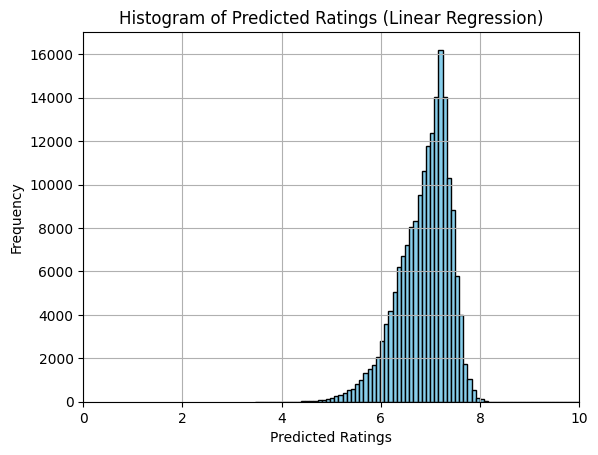

In [ ]:
# Plot individual histograms of y_pred_ln vs. y_val
# Plot histogram of predicted ratings y_pred_ln from Linear Regression
plt.hist(y_pred_ln, bins=200, color='skyblue', edgecolor='black')
plt.title('Histogram of Predicted Ratings (Linear Regression)')
plt.xlabel('Predicted Ratings')
plt.ylabel('Frequency')

plt.xlim(0, 10)

plt.grid(True)
plt.show()

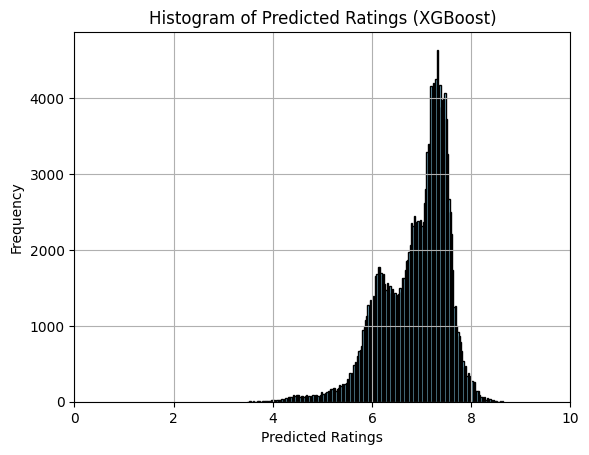

In [ ]:
# Plot individual histograms of y_pred_ln vs. y_val
# Plot histogram of predicted ratings y_pred_ln from Linear Regression
plt.hist(y_pred_xgb, bins=200, color='skyblue', edgecolor='black')
plt.title('Histogram of Predicted Ratings (XGBoost)')
plt.xlabel('Predicted Ratings')
plt.ylabel('Frequency')

plt.xlim(0, 10)

plt.grid(True)
plt.show()

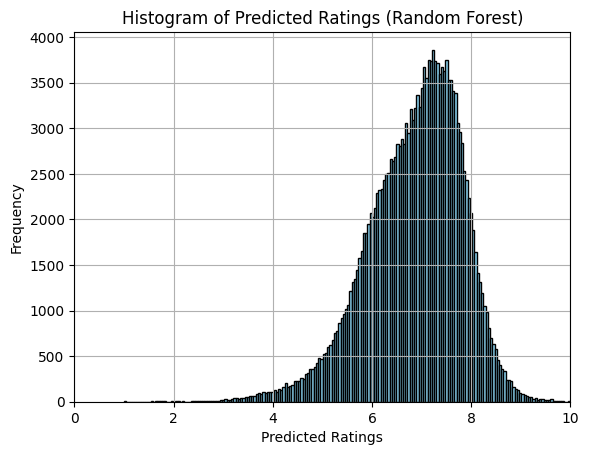

In [ ]:
# Plot individual histograms of y_pred_rf vs. y_val
# Plot histogram of predicted ratings y_pred_rf from Random Forest
plt.hist(y_pred_rf, bins=200, color='skyblue', edgecolor='black')
plt.title('Histogram of Predicted Ratings (Random Forest)')
plt.xlabel('Predicted Ratings')
plt.ylabel('Frequency')

plt.xlim(0, 10)

plt.grid(True)
plt.show()

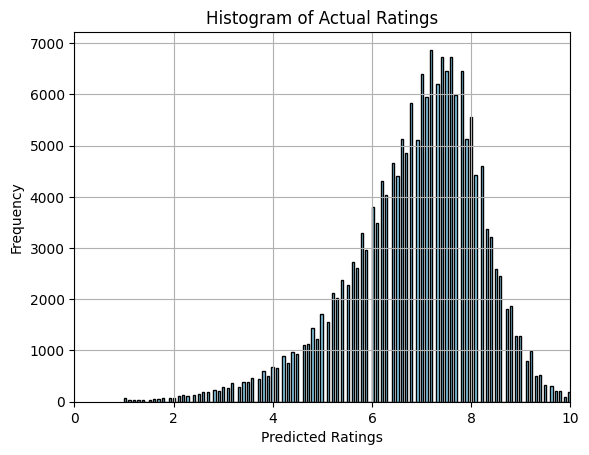

In [ ]:
# Plot histogram of predicted ratings y_pred_ln from Linear Regression
plt.hist(y_val, bins=200, color='skyblue', edgecolor='black')
plt.title('Histogram of Actual Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Frequency')

plt.xlim(0, 10)

plt.grid(True)
plt.show()

# Best Model Performance - Random Forest

In [ ]:
# Testing Random Forest model performance on test set

# Make predictions on the test set
y_pred_rf_test = rf_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
print(f'Mean Squared Error (MSE): {mse_rf_test}')

root_mse_rf_test = np.sqrt(mse_rf_test)
print(f'Root Mean Squared Error (RMSE): {root_mse_rf_test}')

Mean Squared Error (MSE): 1.062736288945749
Root Mean Squared Error (RMSE): 1.0308910170070107


The MSE obtained by the fitted random forest model on the test set is just slightly higher (by 0.01 only) than the MSE obtained on the validation set. It is lower than the MSE by the other two models on the validation set. Moreover, the distribution of predicted Y values is very close to the actualy distribution, using random forest model.